In [10]:
# System
import os
import sys
sys.path.append('../src')

# Core Python libraries
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Scikit-learn (ML + preprocessing)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Joblib (saving/loading models)
import joblib

# PyTorch & Transformers
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# Project-specific modules
from preprocess import load_and_prepare_data, clean_text,SentimentDataset
from train import train_and_save_models
from evaluate import evaluate_and_save_results


In [11]:
df = pd.read_csv("../datasets/data.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


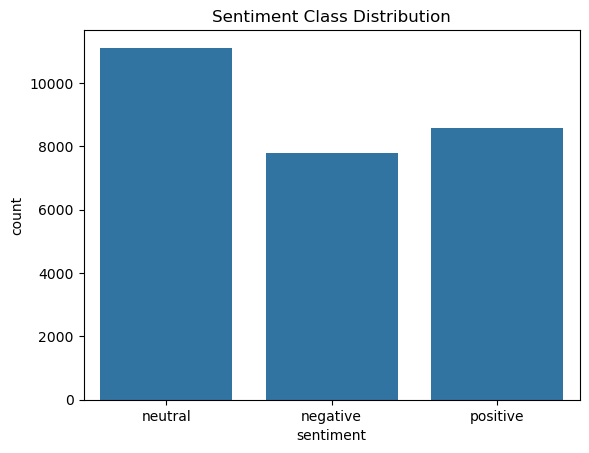

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [12]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.show()

# Check missing values
df.isnull().sum()


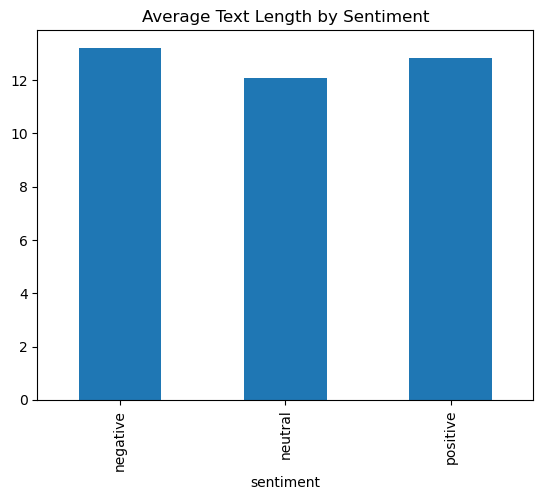

In [13]:
# Apply cleaning
df['cleaned_text'] = df['text'].astype(str).apply(clean_text)

# Example: average length of text by label
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df.groupby('sentiment')['text_length'].mean().plot(kind='bar')
plt.title("Average Text Length by Sentiment")
plt.show()


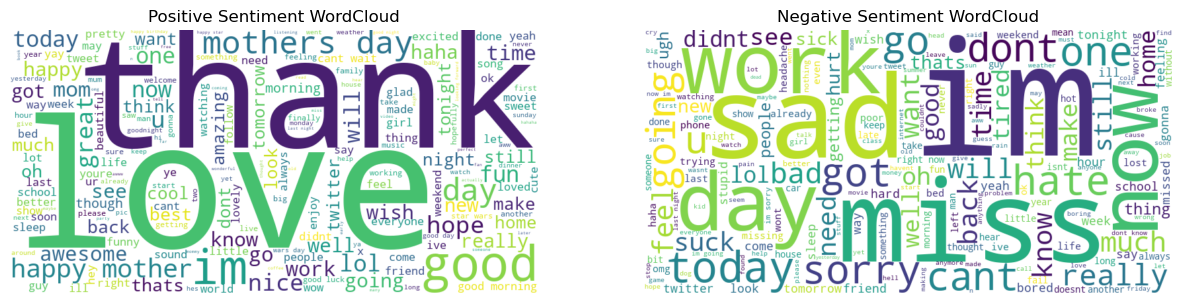

In [14]:
# 5️⃣ WordCloud visualization
positive_text = " ".join(df[df['sentiment']=='positive']['cleaned_text'])
negative_text = " ".join(df[df['sentiment']=='negative']['cleaned_text'])
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Positive Sentiment WordCloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Negative Sentiment WordCloud")
plt.axis('off')
plt.show()


In [15]:
df.head()

,textID,text,selected_text,sentiment,cleaned_text,text_length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the rele...,13


In [16]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
cleaned_text     0
text_length      0
dtype: int64

In [17]:
df.dropna(inplace=True)

In [18]:
df.isna().sum()

textID           0
text             0
selected_text    0
sentiment        0
cleaned_text     0
text_length      0
dtype: int64

In [20]:
# 6️⃣ Quick model test (small subset for sanity check)
X_train, X_test, Y_train, Y_test,le = load_and_prepare_data("../datasets/data.csv")

In [28]:
# Train classical models using your src script
results = train_and_save_models(X_train,Y_train,X_test,Y_test)
print("Quick model accuracy comparison:", results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.613800,0.581762,0.769511
2,0.368700,0.610696,0.783882


Quick model accuracy comparison: ({'logistic_class': 0.6931053301800982, 'naive_bayes': 0.6398035291977442, 'bert': np.float64(0.7695106421684555)}, array([2, 1, 1, ..., 0, 2, 2]))



Classification Report for logistic_class:
              precision    recall  f1-score   support

    negative       0.73      0.61      0.67      1562
     neutral       0.63      0.75      0.68      2230
    positive       0.77      0.70      0.73      1705

    accuracy                           0.69      5497
   macro avg       0.71      0.69      0.69      5497
weighted avg       0.70      0.69      0.69      5497



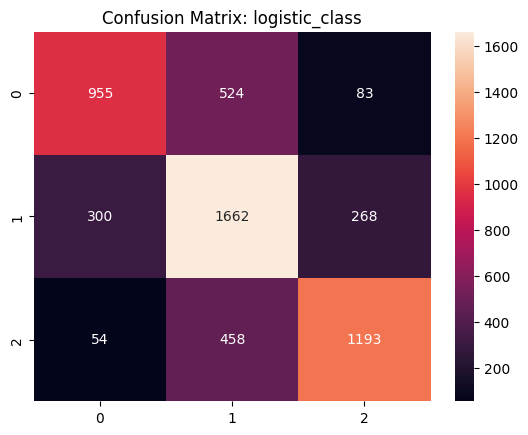


Classification Report for naive_bayes:
              precision    recall  f1-score   support

    negative       0.75      0.47      0.58      1562
     neutral       0.56      0.79      0.66      2230
    positive       0.76      0.59      0.66      1705

    accuracy                           0.64      5497
   macro avg       0.69      0.62      0.63      5497
weighted avg       0.67      0.64      0.64      5497



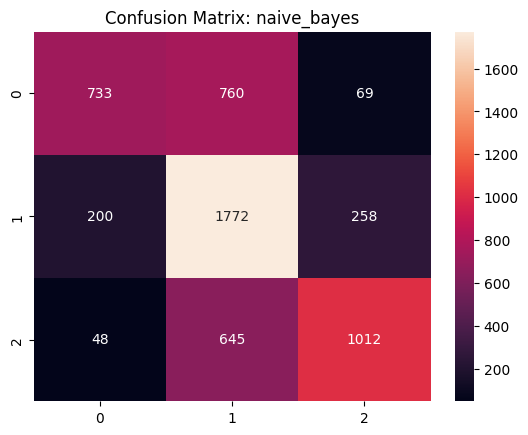


Classification Report for bert:
              precision    recall  f1-score   support

    negative       0.78      0.80      0.79      1562
     neutral       0.75      0.70      0.73      2230
    positive       0.78      0.83      0.80      1705

    accuracy                           0.77      5497
   macro avg       0.77      0.78      0.77      5497
weighted avg       0.77      0.77      0.77      5497



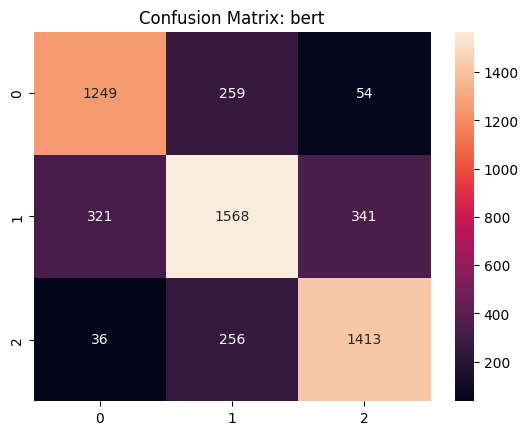

In [36]:
classical_results, bert_preds = results

evaluate_and_save_results(X_test, Y_test, bert_preds, le)